# TP2 de robótica

Caio Teles Cunha - 2020006434

Ivan Vilaça de Assis - 2021421931

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.image as mpimg
import matplotlib.patches as patches
import networkx as nx
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [2]:
def Rx(theta):
 
    return np.array([[  1, 0            , 0           ],
                      [ 0, np.cos(theta),-np.sin(theta)],
                      [ 0, np.sin(theta), np.cos(theta)]])
  
def Ry(theta):
 
    return np.array([[  np.cos(theta), 0, np.sin(theta)],
                      [ 0            , 1, 0           ],
                      [-np.sin(theta), 0, np.cos(theta)]])


def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

# Plota um referencial no plano
def plot_frame(Porg, R, c=None):

    axis_size = 1.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
    
    if c == None:
        c = ['r', 'g']
    
    # X
    plt.quiver(*Porg[0:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[0:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

## Funções para obter posição, angulos de euler e plotar referenciais

In [3]:
def getPosition(handleObject):
    position = sim.getObjectPosition(handleObject)
    position = np.array(position)
    return position

In [4]:
def getEulerAngles(handleObject):
    eulerAngles = sim.getObjectOrientation(handleObject)
    eulerAngles = np.array(eulerAngles)
    return eulerAngles

In [5]:
def getRelativePosition(handleObject,handleReference):
    position = sim.getObjectPosition(handleObject,handleReference)
    position = np.array(position)
    return position

In [6]:
def getRelativeEulerAngles(handleObject,handleReference):
    eulerAngles = sim.getObjectOrientation(handleObject,handleReference)
    eulerAngles = np.array(eulerAngles)
    return eulerAngles

In [7]:
# (firstFrame -> second frame)
# T (secondFrame,fistFrame)
# Ao multiplicar um ponto do primeiro frame, ele se transforma em um ponto em relação
# ao segundo frame
def getTransformationMatrix(fistFrameHandle,secondFrameHandle):

    fistFramePosition = getRelativePosition(fistFrameHandle,secondFrameHandle)
    fistFrameOrientation = getRelativeEulerAngles(fistFrameHandle,secondFrameHandle)

    Rsf = Rz((fistFrameOrientation[2]))

    # Concatena o vetor origem ao final (coluna)
    Tsf = np.column_stack((Rsf, fistFramePosition))
    # Concatena o vetor auxiliar embaixo (linha)
    aux = np.array([0, 0, 0, 1])
    Tsf = np.row_stack((Tsf, aux))

    return Tsf

In [8]:
def getShapeGeometricInfo(objectPath):
    objectHandle = sim.getObject(objectPath)
    _, _, dimensions = sim.getShapeGeomInfo(objectHandle)

    return dimensions

## Campos potenciais - Robô Diferencial

### Introdução

O algoritmo de campos potênciais é um algoritmo reativo que se inspira na física para guiar um robô até um ponto alvo. O robô é atraído por um ponto alvo e repelido por obstáculos. A força de atração é proporcional a distância do robô, diminuindo quanto mais próximo o alvo, e a força de repulsão é inversamente proporcional distância do robô ao obstáculo, ou seja, quanto menor a distância do robô para obstáculo maior a força de repulsão. A força resultante é a somatória da força de atração e das forças de repulsão geradas por todos os objetos dos quais o robô sabe que existem e estão dentro de um limite definido de inflûencia, o que impede que um obstáculo muito longe influencie na tragetória. O robô se move na direção da força resultante.

Apesar do algoritmo funcionar em alguns casos, ele não é completo, ou seja, não garante que caso exista um caminho ele vai encontrá-lo. Isso ocorre pois o robô pode ficar preso em mínimos locais, onde a força de repulsão se cancela com a força de atração, ou pode ficar preso em um loop infinito, onde a força resultante o faz andar em círculos.

### Implementação

#### Algoritmo de campos potenciais

Para esse trabalho será implementado o algoritmo de campos potênciais reativos, ou seja, o robô tomará apenas os objetos dentro do campo de visão dos lasers. Transcrevi abaixo os códigos de leitura do laser atualizados para api nova que foram escritos por nós no trabalho anterior.

In [9]:
# atualizando para a versão mais nova da API
def readSensorData(range_data_signal_id="hokuyo_range_data", angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if string_angle_data and string_range_data:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return [],[]

##### Funções de definição dos campos de repulsão e de atração.

A função da força de atração foi definida como:

In [10]:
def att_force(q, goal, katt=0.1):
    return katt*(goal - q)

O coeficiente katt é um coeficiente de proporcionalidade que foi escolhido testando valores diferentes e observando o comportamento do robô. Também levamos em consideração à grandeza para que as forças de atração e repulsão fossem equiparáveis.

Para a função de repulsão foi utilizada a equação dada em sala de aula abaixo para o cálculo:

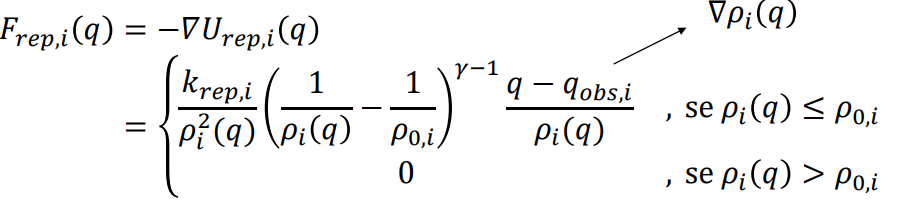

A força de repulsão é oposta ao objeto encontrado.

Variáveis:
*  k_{rep,i} : apenas uma constante de ganho, foi definida arbitrarimente, decidi também que todos os objetos teriam a mesma constante para facilitar os cálculos
*  pi(q) : A distância que um laser detectou um objeto, ou seja, a distância do robô ao objeto.
*  po_{0,i} : uma constante que representa a distância mínima que um objeto deve ter para gerar uma força de repulsão no robô, também foi definida arbitrariamente.
*  gamma(y) : outra constante, utilizei o valor 2 conforme orientado pelo professor
*  q : a posição atual do robô.
*  q_{obs,i} : a coordenada x,y do ponto de contato do laser com o obstáculo no referencial do mundo.

Vale ressaltar que o ponto utilizado na última parte da equação está no referencial do mundo. Para conseguir esse valor, utilizamos uma transformada que pega o ponto no referencial do robô e transforma em um ponto no referencial do mundo.

In [11]:
def rep_force(q, obs,minInfluencialDistance = 2, krep=0.1):
    # Obstáculo: ([x, y],dist)
    # k rep  = 0.1
    # pi(q) = obs[1]
    # minInfluencialDistance = 2
    # y = 2
    # q = q
    # q_obs = obs[0]
    escalar = krep/(obs[1]**2)
    escalar *= (1/obs[1]) - (1/minInfluencialDistance)
    delta_x = (escalar * ((q[0] - obs[0][0]) / obs[1]))
    delta_y = (escalar * ((q[1] - obs[0][1]) / obs[1]))
    return np.asarray([delta_x, delta_y])

Essa função recebe os dados do laser e filtra quais estão na distância de mínima para influenciar o robô, posteriormente usa uma transformada para para mudar o ponto do referencial do robo para o referencial do mundo. Utilizar o referencial do mundo facilita as contas e evita que tenhamos que multiplicar pelo negativo dos vetores o tempo inteiro. Além de ficar mais fácil a compreensão já que o vetor de atração usa o objetivo (goal) no referêncial do mundo que pode ou não ser visível pelo laser. Utilizei a tranformada do robô, já que ela e a do laser são praticamente iguais e facilitaria o cálculo. Novamente, a função utilizada para a transformada foi a mesma utilizada no trabalho anterior. Essa função pega a posição dos objetos e sua orientação e monta a matriz de transformação. Posteriormente, com a matriz de transformação pronata, basta multiplicar o ponto no frame do robô por ela e o ponto resultante estará no frame do mundo. Testamos manualmente a transformada para garantir que ela estaria correta.

A distância mínima de influência foi definida também arbitrariamente observando o comportamento do robô em vários testes.

In [12]:
def getObstaclesPosition(laser_data,transformation_matrix,minInfluencialDistance = 2):
    obstaclesList = []
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        if dist < minInfluencialDistance:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            point_laser = np.array([x,y,0,1])
            point_world = transformation_matrix @ point_laser
            obstaclesList.append([point_world[:2],dist])
    return obstaclesList

Essa função calcula a força de repulsão de cada ponto visto pelo laser e soma para gerar o vetor de repulsão resultante. Ela é necessária, pois queremos que todos os pontos que estão no campo de visão do laser influenciem o robô trazendo um melhor resultado.

In [13]:
def getRepulsionForce(obstaclesList,robotPosition):
    accumulative = [0,0]
    for obstacle in obstaclesList:
        rep = rep_force(robotPosition, obstacle)
        accumulative[0] =  accumulative[0] + rep[0]
        accumulative[1] =  accumulative[1] + rep[1]
    return accumulative

Essa função foi utilizada durante os testes para plotar o vetor resultante deixando mais fácil perceber se as contas estariam dentro do esperado.

In [14]:
def  plotVetorResultante(Fatt):
    pr_org = np.array([0,0]) # origin point
    fig = plt.figure(figsize=(6,3), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.quiver(*pr_org[:2], *Fatt, color='blue', angles='xy', scale_units='xy', scale=1)
    plt.show()

##### Controlador

Nesse código foi implementado o controlador que será utilizado nos testes nas diferentes cenas. O controlador de robô diferencial escolhido foi ([De Luca e Oriolo, 1994]) pela facilidade na sua implementação e na simplicidade do entendimento. A função recebe os valores arbitrarios escolhidos e roda a simulação no robô na cena. Também acrescentamos uma condição de tempo no while para limitar o loop de movimentação do robô, para que no caso de o robô ficar preso em um mínimo local a função não rode para sempre.

In [25]:
def runSimulation(sim,kr=1,kt=1,goal=[10,-8]):

    sim.startSimulation()

    goal = goal

    # Handle do Robo
    robotHandle = sim.getObject("/Pioneer_p3dx")
    robotPosition = getPosition(robotHandle)
    # World Handle 
    worldHandle = sim.handle_world

    # Handle Laser
    laserHandle = sim.getObject("/Pioneer_p3dx/fastHokuyo")

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    # Handle para as juntas das RODAS
    l_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_leftMotor")
    r_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_rightMotor")

    # Faz a matriz de transformação
    Tur = getTransformationMatrix(robotHandle,worldHandle)

    # Prosseguindo com as leituras
    raw_range_data = [] 
    raw_angle_data = []
    while len(raw_range_data) == 0 and len(raw_angle_data) == 0:
        raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    # Dados do Pioneer
    L = 0.381   # Metros
    r = 0.0975  # Metros
    maxv = 1.0
    maxw = np.deg2rad(45)
    rho = np.inf
    t = 0
    while rho > .05 and (t := sim.getSimulationTime()) < 60:
        # Fazendo a leitura da posição
        # Esse ponto é a posição do robô em relação ao mundo
        robotPosition = getPosition(robotHandle)

        # Fazendo a leitura da orientação
        robotOrientation = getEulerAngles(robotHandle)

        # Faz a matriz de transformação
        Tur = getTransformationMatrix(robotHandle,worldHandle)

        # Fazendo leituras do laser
        raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T

        obstaclesList = []
        obstaclesList = getObstaclesPosition(laser_data,Tur)
        
        Fatt = att_force(robotPosition[:2] , goal)
        Frep = getRepulsionForce(obstaclesList,robotPosition[0:2])

        robotConfig = np.array([robotPosition[0], robotPosition[1], robotOrientation[2]])

        #somar a esse dx,dy as forças de repulsão e atração
        dx = Fatt[0] + Frep[0]
        dy = Fatt[1] + Frep[1]
        Fresult = np.asarray([dx, dy])

        # Apenas para interromper o loop
        rho = np.sqrt(dx**2 + dy**2)

        kr = kr
        kt = kt
        
        v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(dy,dx) - robotConfig[2])

        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)

        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)
        
        # Enviando velocidades
        sim.setJointTargetVelocity(l_wheel, vl)
        sim.setJointTargetVelocity(r_wheel, vr)
        sim.step()
    
    sim.setJointTargetVelocity(l_wheel, 0)
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.stopSimulation()
       
    return t

Para testar basta abrir uma das cenas e selecionar a posição do robô. Opicionalmente pode-se mudar a posição do objetivo passando um array de duas posições [x,y] para a função tomando o cuidado de a coordenada estar no referencial do mundo e ser uma posição valida dentro da cena.

In [23]:
client = RemoteAPIClient()
sim = client.getObject('sim')
runSimulation(sim)
# necessário para fechar a conexão
time.sleep(3)

38.84999999999993


##### Testes

Os testes serão dividos entre dois mapas. Os dois mapas não são muito simples e o objetivo é comparar o tempo de execução e a eficiência do algoritmo de campos potenciais, os diferentes valores de constantes, bem como evidenciar as falhas do algoritmo.

##### Mapa Maze 2

###### Configuração

Primeiramente vamos testar a diferença de tempo para o robô alcançar o ponto alvo variando os valores de kr e kt para o mapa cave. O objetivo é verificar como essas constantes do controlador influenciam no tempo de execução do algoritmo.

Nesse teste selecionamos a posição do robô para (-15,15), e a orientação com 0 de alteração para todos os eixos, e o goal para (-7,22). O objetivo é que seja um teste simples que o algoritmo seja capaz de encontrar um caminho facilmente para podemor calcular o resultado.

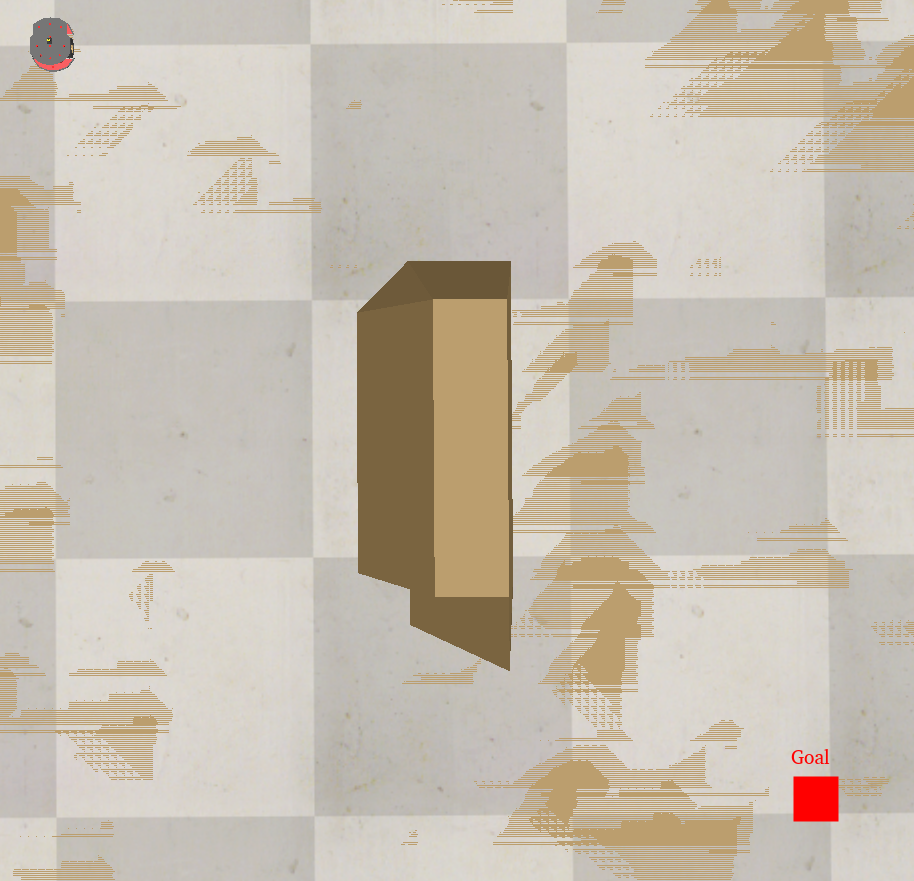

Com pequenas variações o robô executou o seguinte caminho:

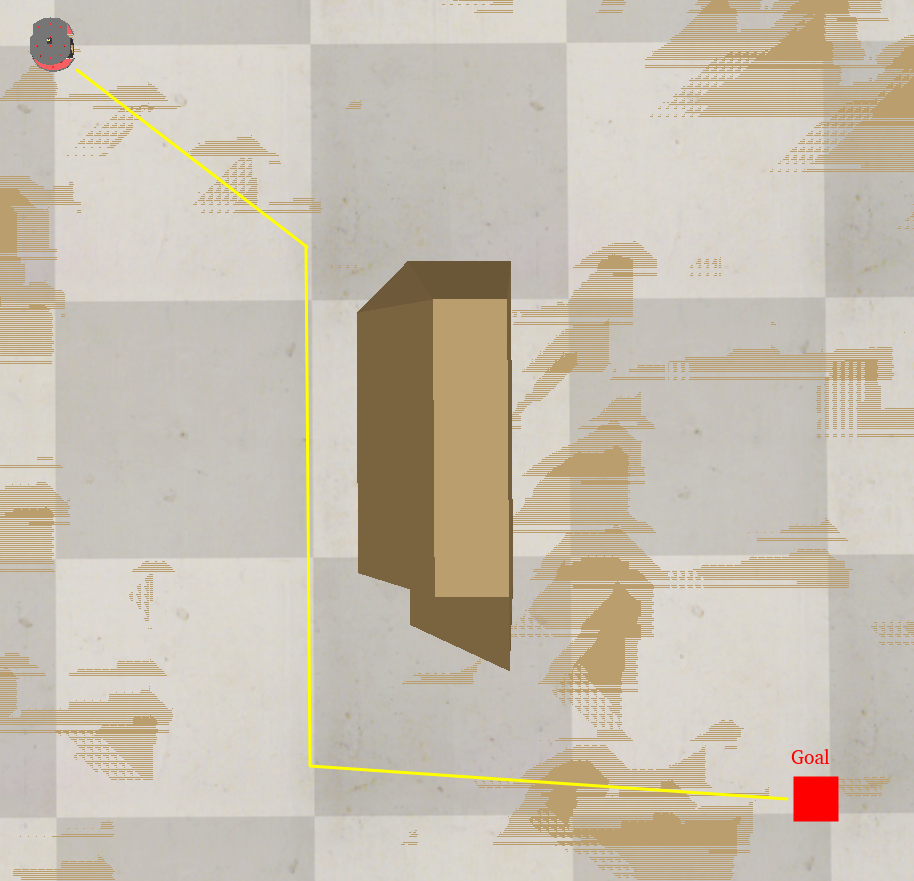

Esse código simplesmente executa a função várias vezes com diferentes valores de kr e kt e plota o tempo de execução em uma tabela.

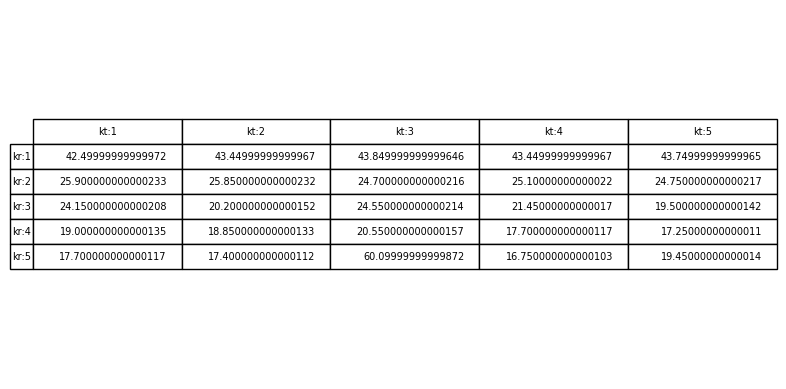

In [31]:
goal = np.array([-7,22])
kr = np.array([1,2,3,4,5])
kt = np.array([1,2,3,4,5])
times = []

for i in kr:
    row = []
    for j in kt:
        client = RemoteAPIClient()
        sim = client.getObject('sim')
        start_time = time.time()
        t = runSimulation(sim,i,j,goal=goal)
        row.append(t)
        # necessário para fechar a conexão
        time.sleep(3)
    times.append(row)
        
columns = ['kt:%d' % x for x in kr] 
rows = ['kr:%d' % x for x in kt]


table = plt.table(cellText=times,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')
table.set_fontsize(20)
table.scale(1.5, 1.5)
plt.axis('off')
plt.savefig("table.png")
plt.show()

A tabela seguinte mostra os resultados obtidos:

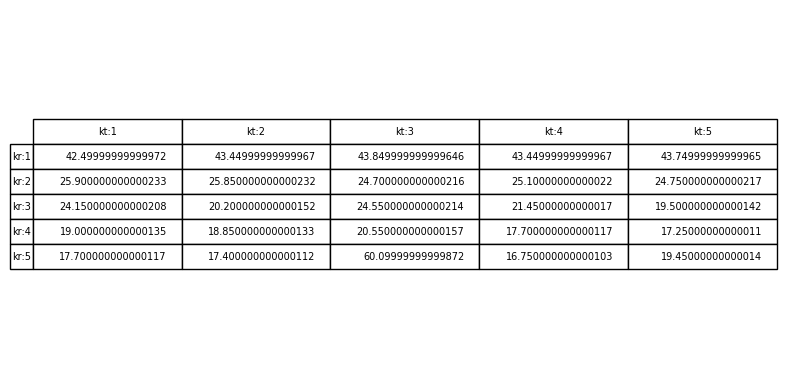

Analisando a tabela podemos perceber que com o aumento dos valores de kr a tendência é a diminuição do tempo, o que faz sentido já que estamos aumentando a velocidade linear do robô. No entanto, com uma configuração (kr=5 e kt=3) o robô não conseguiu executar o caminho como visto pelo valor na tabela com 1 minuto de duração, já que acelerou muito e acabou ficando preso no obstáculo, então é preciso analisar de o ganho de tempo vale a pena.

Analisando os valores de kt podemos perceber que o tempo de execução não tem um padrão muito bem definido com seu aumento ou diminuição. No entanto é preciso considerar que o aumento desse coeficiente faz com que o robo realize viradas mais bruscas enquanto o diminuição faz com que o robô realize viradas mais suaves. Isso é um fator que deve ser considerado na escolha do valor de kt.

Tendo esses dados, escolhi arbitrariamente uma das configurações, no caso (kt = 2 e kr = 4), para testar as outras variáveis e constantes envolvidas no algoritmo. Escolhi essa configuração por não ser nem o menor tempo, nem o maior tempo, e por ter um tempo razoável de execução. Levei em conta que viradas bruscas não são desejáveis, então escolhi um valor de kt menor.

## Roadmap com decomposição de células - Robô holonômico

### Algoritmo de decomposição em células - Grid

In [ ]:
def getAndPlotMap(mapPath, threshold=0.5):
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = 1 - mpimg.imread(mapPath)

    # Apenas para garantir que só teremos esses dois valores
    img[img > threshold] = 1
    img[img<= threshold] = 0

    ax.imshow(img, cmap='Greys', origin='upper')

    return img

In [ ]:
def createAndPlotCellGrid(img, cell_size, map_dims,threshold=0.5):
    # Dimensões do mapa informado em metros (X, Y)
    # map_dims = np.array([70, 70]) # Mapa
    # map_dims = np.array([50, 50]) # Mapa2

    # Escala Pixel/Metro
    sy, sx = img.shape / map_dims

    # # Tamanho da célula do nosso Grid (em metros)
    # cell_size = 1

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                            
            grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0        

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    return rows, cols, grid

In [ ]:
def createAndPlotGridGraph(cell_size, rows, cols, grid, map_dims):
    # Criando o Grafo para o nosso Grid

    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 

    # Removendo células que estão em células marcas com obstáculos
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:  
                G.remove_node((r,c))


    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    # Os vértices serão plotados no centro da célula  
    pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

    return G, pos

In [ ]:
def findAndPlotPath(start_node, end_node, G, map_dims, grid, pos):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    # Caminho
    path = nx.shortest_path(G, source=start_node, target=end_node)

    # Plotando pontos inicial e final e o caminho encontrado
    nx.draw_networkx_nodes(G, pos, nodelist=[path[0], path[-1]], node_size=100, node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=path[1:-1], node_size=100, node_color='b')

    return path

In [ ]:
def convertCellFromSquareGridToWorld(dimension, firstPart_Y, secondPart_X):
    globalOffset = dimension / 2

    world_Y = globalOffset - firstPart_Y
    world_X = -1 * (globalOffset - secondPart_X)
        
    return world_X, world_Y

def convertPath(path):
    # Recuperando os dados geométricos do mapa
    dimensions = getShapeGeometricInfo("/heightfield")
    convertedPath = []

    for p in path:
        convertedPath.append(convertCellFromSquareGridToWorld(dimensions[0], p[0], p[1]))

    return convertedPath

In [ ]:
def proportionalHolonomicController(sim, qGoal):
    # Handle do Robo
    robotHandle = sim.getObject("/robotino")
    if robotHandle == -1:
        print("Falha ao pegar o handle do robô.")
        return

    # Handles para as rodas do robô
    wheel1 = sim.getObject("/robotino/wheel0_joint")
    wheel2 = sim.getObject("/robotino/wheel1_joint")
    wheel3 = sim.getObject("/robotino/wheel2_joint")

    if (wheel1 == -1 or wheel2 == -1 or wheel3 == -1):
        print("Falha ao pegar os handles das rodas.")
        return

    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros

    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])

    gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])

    while True:
        # Fazendo a leitura da posição e da orientação
        # Esse ponto é a posição do robô em relação ao mundo
        pos = getPosition(robotHandle)
        ori = getEulerAngles(robotHandle)
        q = np.array([pos[0], pos[1], ori[2]])

        error = qGoal - q

        # Margem aceitável de distância
        if (np.linalg.norm(error[:2]) < 0.1):
            break

        # Controller
        qdot = gain @ error

        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades
        sim.setJointTargetVelocity(wheel1, u[0])
        sim.setJointTargetVelocity(wheel2, u[1])
        sim.setJointTargetVelocity(wheel3, u[2])

    # # Parando o robô    
    # sim.setJointTargetVelocity(wheel1, 0)
    # sim.setJointTargetVelocity(wheel2, 0) 
    # sim.setJointTargetVelocity(wheel3, 0)  

In [ ]:
def pathTranverser(sim, path):
    sim.startSimulation()

    pathWithWorldCoord = convertPath(path)

    for p in pathWithWorldCoord:
        proportionalHolonomicController(sim, [p[0], p[1],0])

    sim.step()
    # Parando a simulação    
    sim.stopSimulation()

#### Encontrando caminhos no mapa 1

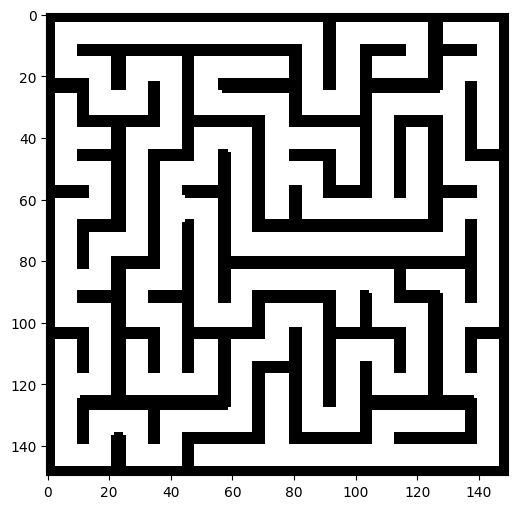

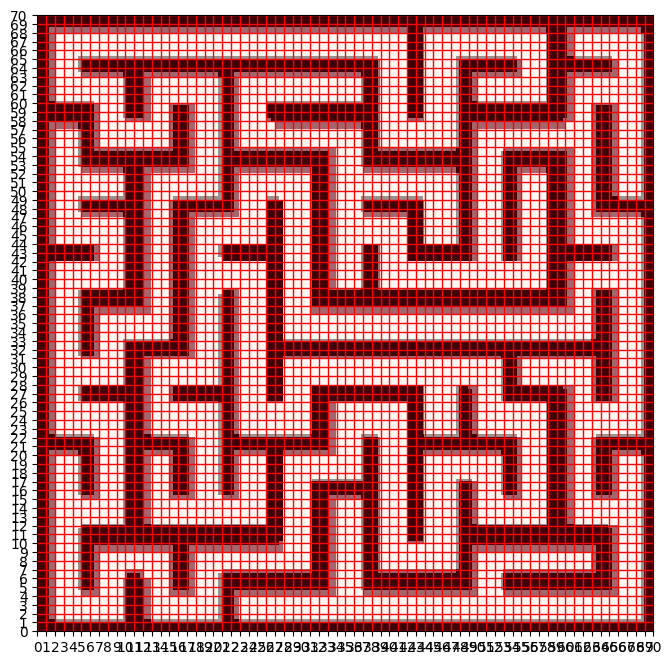

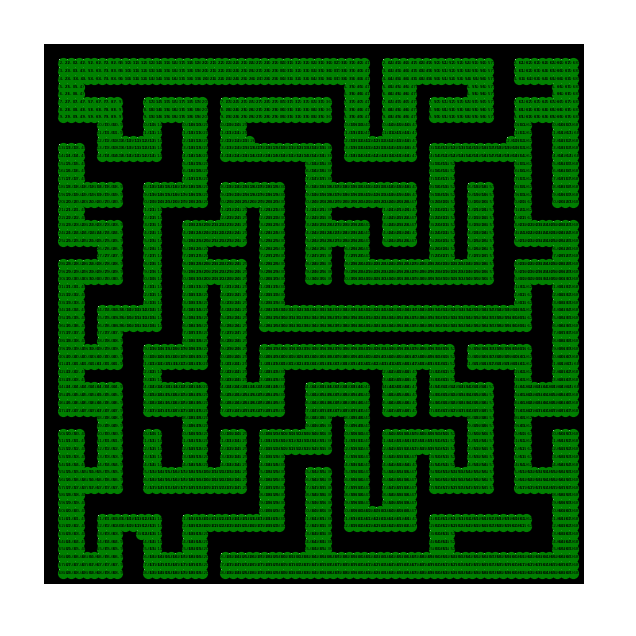

In [ ]:
cell_size = 1

# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([70, 70])


img = getAndPlotMap('img/mapa_invertido.png')
rows, cols, grid = createAndPlotCellGrid(img, cell_size, map_dims)
graph, pos = createAndPlotGridGraph(cell_size, rows, cols, grid, map_dims)

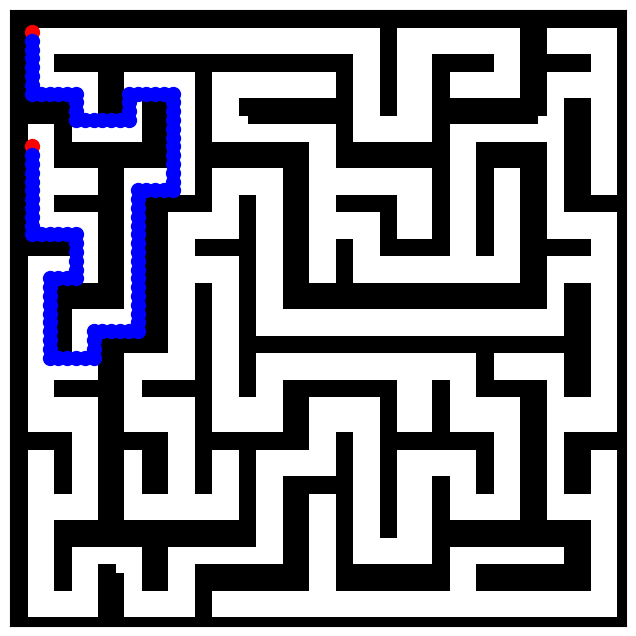

In [ ]:
# Mapa
start_node =  (2, 2) 
end_node = (15, 2) 

path = findAndPlotPath(start_node, end_node, graph, map_dims, grid, pos)

In [ ]:
client = RemoteAPIClient()
sim = client.getObject('sim')
start_time = time.time()
pathTranverser(sim, path)
time.sleep(3)

KeyboardInterrupt: 

#### Encontrando caminhos no mapa 2

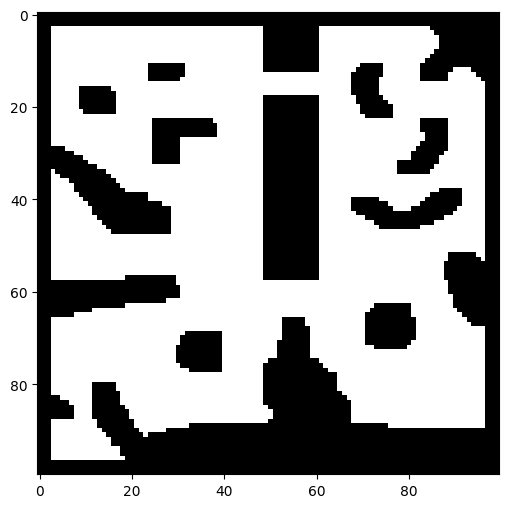

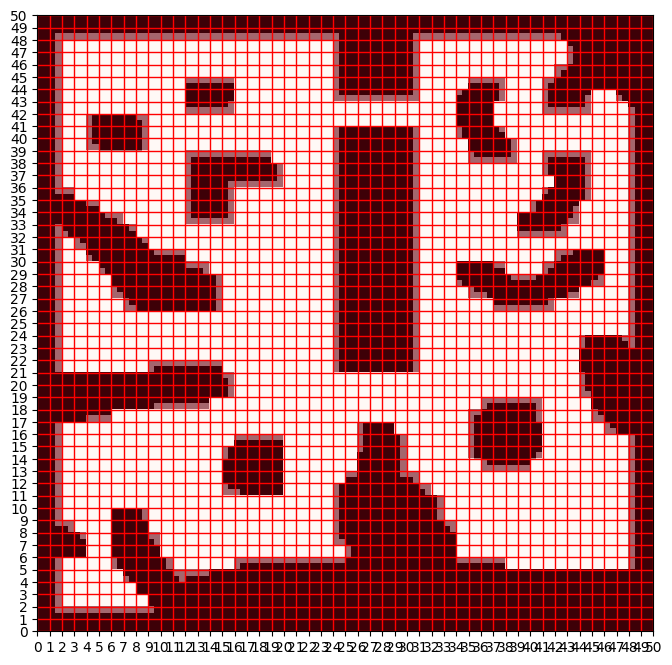

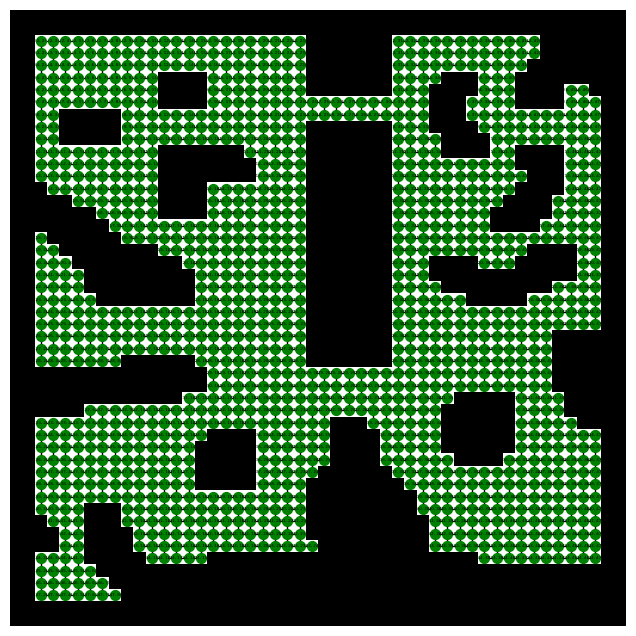

In [ ]:
cell_size = 1

# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([50, 50])


img = getAndPlotMap('img/mapa2_invertido.png')
rows, cols, grid = createAndPlotCellGrid(img, cell_size, map_dims)
graph, pos = createAndPlotGridGraph(cell_size, rows, cols, grid, map_dims)

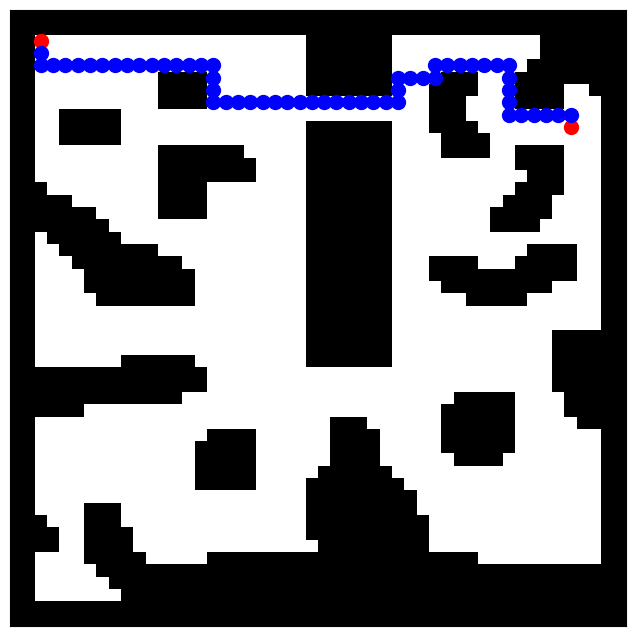

In [ ]:
# Mapa
start_node =  (2, 2) 
end_node = (9, 45) 

path = findAndPlotPath(start_node, end_node, graph, map_dims, grid, pos)

In [ ]:
client = RemoteAPIClient()
sim = client.getObject('sim')
start_time = time.time()
pathTranverser(sim, path)
time.sleep(3)

### Algoritmo de wavefront - Extra

#### Pegando o mapa e discretizando

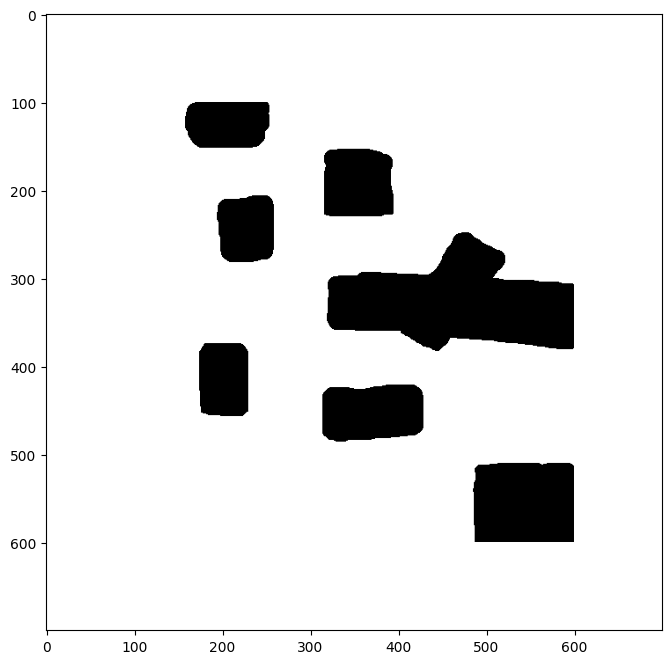

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('img/cave.png')
#img = 1 - mpimg.imread('img/maze.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

35


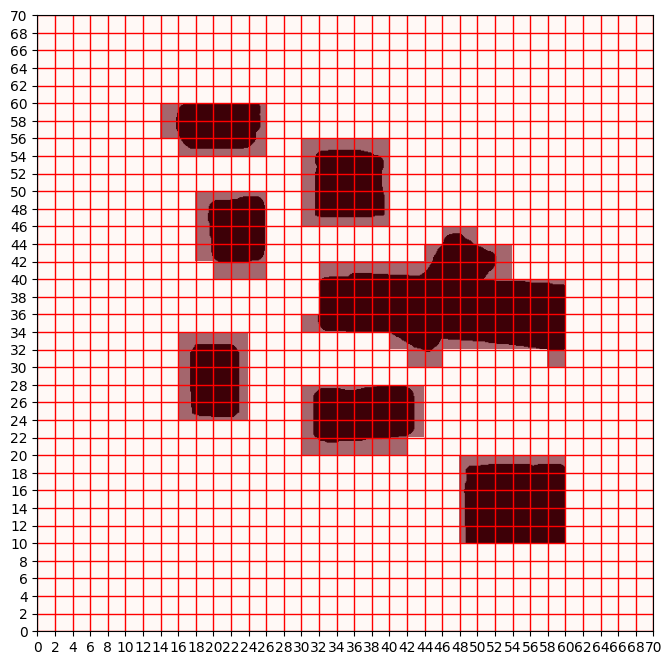

In [ ]:
#np.set_printoptions(threshold=np.inf)
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([70, 70]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
print(rows)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (999) ou Não-ocupadas (0)       
grid[grid > threshold] = 999
grid[grid<= threshold] = 0

#print(grid)
#print(grid[5][7])

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

A premissa é que conhecemos o mapa do ambiente e o goal. Assim, a partir do goal, vamos acrescentar um potencial aos vizinhos de modo que cada ponto no mapa tenha um potencial. A vantagem desse modo é que ele impede minímos locais que poderiam atrapalhar o robô a chegar na posição objetivo.

In [ ]:
def wavefront(goal,grid):

    neighboorsPosition = [[0,+1],[-1,0],[+1,0],[0,-1]]
    
    q = []
    q.append(goal)
    
    potentialGrid = np.copy(grid)
    while len(q) != 0:
        point = q.pop(0)
        x = point[0]
        y = point[1]
        potential = potentialGrid[x][y]
        for px,py in neighboorsPosition:
            neighboorX = px + x
            neighboorY = py + y
            if neighboorX > rows-1 or neighboorY > cols-1:
                continue
            if neighboorX < 0 or neighboorY < 0:
                continue
            if neighboorX == goal[0] and neighboorY == goal[1]:
                continue
            if potentialGrid[neighboorX][neighboorY] == 0:
                potentialGrid[neighboorX][neighboorY] = potential + 1
                q.append([x+px,y+py])
    return potentialGrid

Setando o objetivo para a posição (0,0) por exemplo:

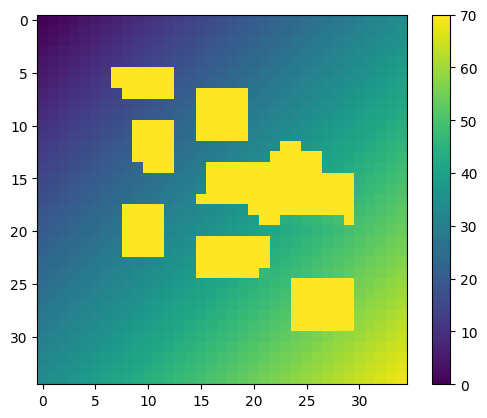

In [ ]:
goal = np.array([0,0])
potentialGrid = wavefront(goal,grid)
plt.imshow(potentialGrid, origin='upper', vmin=0, vmax=70)

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

plt.colorbar()


Dessa forma, o robô em qualquer posição desse grid de potencial conseguiria chegar ao goal saindo da célula em que se encontra para alguma célula vizinha de potencial menor. Vale destacar que foi utilizado uma vizinhança de 8, ou seja, assume que o robô se movimentar de maneira diagonal não é um problema. 

#### Algoritmo de Encontrar o caminho

In [ ]:
def findPath(robotPosition,goal,potentialGrid):
    neighboorsPosition = [[0,+1],[-1,0],[+1,0],[0,-1]]
    q = []
    q.append(robotPosition)

    path = []
    
    while len(q) != 0:
        point = q.pop(0)
        x = point[0]
        y = point[1]
        potential = potentialGrid[x][y]
        for px,py in neighboorsPosition:
            neighboorX = px + x
            neighboorY = py + y
            if neighboorX > rows-1 or neighboorY > cols-1:
                continue
            if neighboorX < 0 or neighboorY < 0:
                continue
            if potentialGrid[neighboorX][neighboorY] < potential:
                q.append([x+px,y+py])
                path.append([x+px,y+py])
                break
    return path

Teste com o robô na posição (34,34) e o objetivo na posição (0,0)

In [ ]:
robotPosition = np.array([20,20])
goal = np.array([0,0])
path = findPath(robotPosition,goal,potentialGrid)
print(path)

[[19, 20], [19, 19], [18, 19], [18, 18], [18, 17], [18, 16], [18, 15], [18, 14], [17, 14], [16, 14], [15, 14], [14, 14], [13, 14], [12, 14], [11, 14], [10, 14], [9, 14], [8, 14], [7, 14], [6, 14], [5, 14], [4, 14], [3, 14], [2, 14], [1, 14], [0, 14], [0, 13], [0, 12], [0, 11], [0, 10], [0, 9], [0, 8], [0, 7], [0, 6], [0, 5], [0, 4], [0, 3], [0, 2], [0, 1], [0, 0]]


Colocando no colormap para fácil visualização

In [ ]:
pathGrid = np.copy(potentialGrid)
for x,y in path:
    pathGrid[x][y] = -1

value = -1

masked_array = np.ma.masked_where(pathGrid == value, pathGrid)

cmap = plt.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='red')

plt.imshow(masked_array, cmap=cmap)
plt.show()

NameError: name 'np' is not defined

#### Controlador

Como se trata da implementação de um robô diferencial precisamos implementar um controlador para sua correta execução. O controlador escolhido foi ([De Luca e Oriolo, 1994]).

In [ ]:
#print ('Program started')
#client = RemoteAPIClient()
#sim = client.require('sim')
#sim.startSimulation()

# Handle para as juntas das RODAS
#l_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_leftMotor")
#r_wheel = sim.getObject("/Pioneer_p3dx/Pioneer_p3dx_rightMotor")

# Handle do Robo
#robotHandle = sim.getObject("/Pioneer_p3dx")

# Esse ponto é a posição do robô em relação ao mundo
#robotPosition = getPosition(robotHandle)

# World Handle 
#worldHandle = sim.handle_world

#robotPosition = np.array([20,20])
#goal = np.array([0,0])
#path = findPath(robotPosition,goal,potentialGrid)
#print(path)

# Dados do Pioneer
#L = 0.381   # Metros
#r = 0.0975  # Metros
#maxv = 1.0
#maxw = np.deg2rad(45)
#rho = np.inf

#for goal in path:
    #while rho > .05:
    
        # Fazendo a leitura da posição
        # Esse ponto é a posição do robô em relação ao mundo
        #robotPosition = getPosition(robotHandle)
    
        # Fazendo a leitura da orientação
        #robotOrientation = getEulerAngles(robotHandle)
    
        #robotConfig = np.array([robotPosition[0], robotPosition[1], robotOrientation[2]])
    
        #dx, dy = goal - robotConfig[:2]
    
        # Apenas para interromper o loop
        #rho = np.sqrt(dx**2 + dy**2)
    
        #kr = 1
        #kt = 2
        
        #v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        #w = kt*(np.arctan2(dy,dx) - robotConfig[2])
    
        # Limit v,w to +/- max
        #v = max(min(v, maxv), -maxv)
        #w = max(min(w, maxw), -maxw)
    
        #vr = ((2.0*v) + (w*L))/(2.0*r)
        #vl = ((2.0*v) - (w*L))/(2.0*r)
        
        # Enviando velocidades
        #sim.setJointTargetVelocity(l_wheel, vl)
        #sim.setJointTargetVelocity(r_wheel, vr)
        #sim.step()

# Parando o robô    
#sim.setJointTargetVelocity(r_wheel, 0)
#sim.setJointTargetVelocity(l_wheel, 0)    

#sim.stopSimulation()
#print ('Program ended')